In [257]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns

M = 6

mu = np.zeros(M)
Sig = np.array([[200,100,-30, 5,110, 3],
                [100,300,40,25,-2, 0],
                [-30,40,200,10, 0,-70],
                [ 5,25,10,500, 2, 0],
                [110,-2, 0, 2,100,60],
                [ 3, 0,-70, 0,60,300]])

D = np.random.multivariate_normal(mean=mu,cov=np.linalg.inv(Sig),size=100).T

D_dash = np.random.multivariate_normal(mean=mu,cov=np.linalg.inv(Sig),size=40).T
D_dash = np.concatenate([D_dash, np.random.multivariate_normal(mean=mu,cov=np.linalg.inv(Sig),size=20).T], axis=1)
D_dash[3,-20:] = np.random.normal(loc=0, scale=10, size=20)
D_dash = np.concatenate([D_dash, np.random.normal(loc=0, scale=1, size=(6,20))], axis=1)
D_dash = np.concatenate([D_dash, np.random.normal(loc=0, scale=2, size=(6,20))], axis=1)

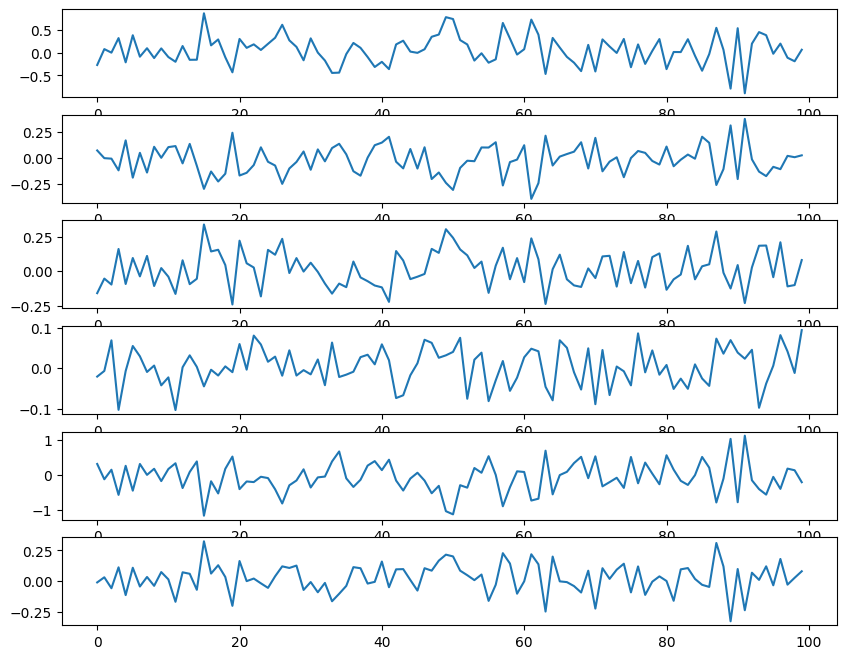

In [258]:
fig, ax = plt.subplots(6,1,figsize=(10,8))
for i in range(6):
    ax[i].plot(D[i].T);

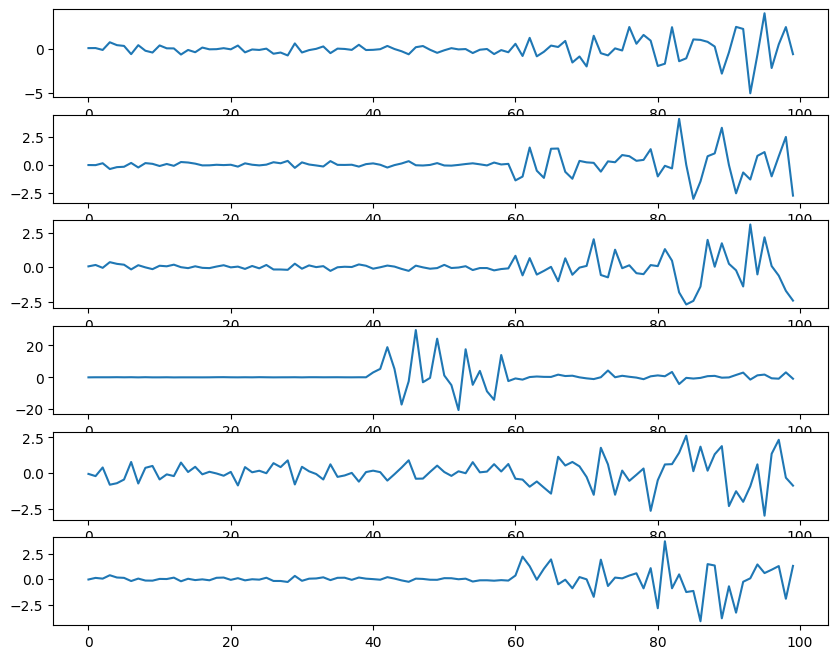

In [259]:
fig, ax = plt.subplots(6,1,figsize=(10,8))
for i in range(6):
    ax[i].plot(D_dash[i].T);

In [408]:
def gauss_kernel(x, h):
    return np.exp(-np.sum((x - x.transpose(0,2,1))**2, axis=0)/(2*(h**2)))

def density_ratio(x1, x2, theta, h):
    r = np.sum(theta*np.exp(-np.sum((x1 - x2.transpose(0,2,1))**2, axis=0)/(2*(h**2))), axis=1)
    r[r<=0] = 1e-5
    return r

K = 5
h = np.arange(0.2,4.2,0.1)
eta = 0.01
N = D.shape[1]
N_dash = D_dash.shape[1]
window1 = int(N//K)
window2 = int(N_dash//K)

Dk = D.reshape(-1,K, int(D.shape[1]/K)).transpose(1,0,2)
D_dashk = D_dash.reshape(-1,K, int(D_dash.shape[1]/K)).transpose(1,0,2)
J = np.zeros((len(h), K))

for t in np.arange(len(h)):
    ht = h[t]
    for k in range(K):
        start1=k*window1
        end1=k*window1+k*window1
        start2=k*window2
        end2=k*window2+k*window2
        
        Dk_test = np.concatenate([D[:,:start1], D[:,end1:]], axis=1).reshape(6,-1,1)
        D_dashk_test = np.concatenate([D_dash[:,:start2], D_dash[:,end2:]], axis=1).reshape(6,-1,1)

        Dk_val = D[:,start1:end1].reshape(6,-1,1)
        D_dashk_val = D_dash[:,start2:end2].reshape(6,-1,1)
        
        N1 = Dk_test.shape[1]
        N_dash1 = D_dashk_test.shape[1]
        
        N2 = Dk_val.shape[1]
        N_dash2 = D_dashk_val.shape[1]

        theta = np.ones(N1)/N1
        dj_ddash = np.sum(gauss_kernel(D_dashk_test, ht), axis=0)/N_dash1
        for _ in range(100):
            dJ = dj_ddash - np.sum(gauss_kernel(Dk_test, ht)/(theta.T@gauss_kernel(Dk_test, ht)), axis=1)/N1
            theta = theta - eta*dJ
            if np.sum(dJ**2) < 1e-2:
                break
        J[t,k] = np.sum(density_ratio(D_dashk_val, D_dashk_test, theta, ht))/N_dash2 - np.sum(density_ratio(Dk_val, Dk_test, theta, ht))/N2

t_best = np.argmin(np.mean(J, axis=1))
h_best = h[t_best]
h_best

C:\Users\00220900095\AppData\Local\Temp\ipykernel_14468\2871987324.py:48: RuntimeWarning: invalid value encountered in double_scalars
  J[t,k] = np.sum(density_ratio(D_dashk_val, D_dashk_test, theta, ht))/N_dash2 - np.sum(density_ratio(Dk_val, Dk_test, theta, ht))/N2


0.2

In [409]:
theta = np.ones(N1+N2)/(N1+N2)
dj_ddash = np.sum(gauss_kernel(D_dash.reshape(6,-1,1), h_best), axis=0)/(N_dash1+N_dash2)
for _ in range(200):
    dJ = dj_ddash - np.sum(gauss_kernel(D.reshape(6,-1,1), h_best)/(theta.T@gauss_kernel(D.reshape(6,-1,1), h_best)), axis=1)/(N1+N2)
    theta = theta - eta*dJ
    if np.sum(dJ**2) < 1e-3:
        break

(-10.0, 100.0)

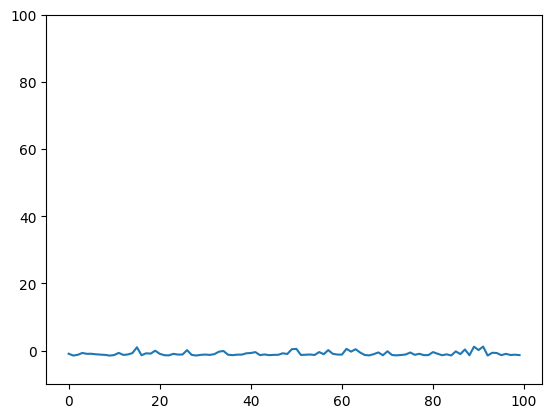

In [410]:
plt.plot(-np.log(density_ratio(D.reshape(6,-1,1), D.reshape(6,-1,1), theta, h_best)))
plt.ylim(-10,100)

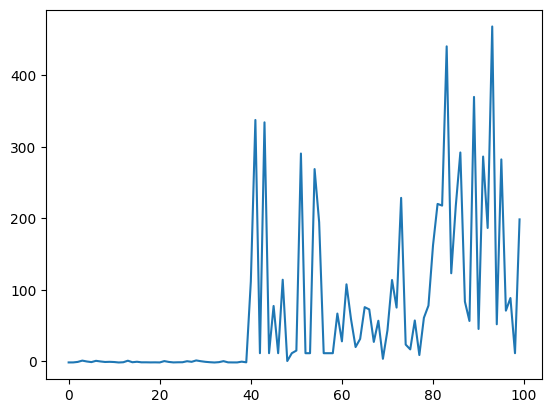

In [411]:
plt.plot(-np.log(density_ratio(D_dash.reshape(6,-1,1), D.reshape(6,-1,1), theta, h_best)))